# Neural closure models for the viscous Burgers equation

In this tutorial, we will train neural closure models for the viscous Burgers
equation in the [Julia](https://julialang.org/) programming language. We here
use Julia for ease of use, efficiency, and writing differentiable code to
power scientific machine learning. This file is available as

- a commented [Julia script](https://github.com/agdestein/NeuralClosure/blob/main/tutorials/burgers.jl),
- a [markdown file](https://github.com/agdestein/NeuralClosure/blob/main/tutorials/burgers.md),
- a Jupyter [notebook](https://github.com/agdestein/NeuralClosure/blob/main/tutorials/burgers.ipynb).

## Running this notebook on Google Colab

_This section is only needed when running on Google colab._
_If you run this notebook on your local machine, skip this section._

To use Julia on Google colab, we will install Julia using the official version
manager Juliup. From the default Python runtime, we can access the shell by
starting a line with `!`.

In [1]:
!curl -fsSL https://install.julialang.org | sh -s -- --yes

We can check that Julia is successfully installed on the Colab instance.

In [2]:
!~/.juliaup/bin/julia -e 'println("Hello")'

We now proceed to install the necessary Julia packages, including `IJulia` which
will add the Julia notebook kernel.

In [3]:
%%shell
~/.juliaup/bin/julia -e '''
    using Pkg
    Pkg.add([
        "ComponentArrays",
        "FFTW",
        "IJulia",
        "LinearAlgebra",
        "Lux",
        "NNlib",
        "Optimisers",
        "Plots",
        "Printf",
        "Random",
        "SparseArrays",
        "Zygote",
    ])
'''

Once this cell has finished running (this may take a few minutes,
depending on what resources Colab decides to give you), do the following:

1. Reload the browser page (`CTRL`/`CMD` + `R`)
2. In the top right corner of Colab, then select the Julia kernel.

   ![](https://github.com/agdestein/NeuralClosure/blob/main/assets/select.png?raw=true)

   ![](https://github.com/agdestein/NeuralClosure/blob/main/assets/runtime.png?raw=true)

## Preparing the simulations

Julia comes with many built in features, including array functionality.
Additional functionality is provided in various packages, some of which are
available in the Standard Library (LinearAlgebra, Printf, Random,
SparseArrays). Others are available in the General Registry, and can be added
using the built in package manager Pkg, e.g. `using Pkg; Pkg.add("Plots")`.
If you ran the Colab setup section, the packages should already be added.

If you cloned the NeuralClosure repository and run this in VSCode,
there should be a file called `Project.toml`, specifying dependencies.
This file specifies an environment, which can be activated.
**If you are running this locally (not on Colab)**:
You can then install the dependencies by uncommenting and running the
following cell:

In [4]:
# using Pkg
# Pkg.instantiate()

Alernatively, you can add them manually:

In [5]:
# using Pkg
# Pkg.add([
#     "ComponentArrays",
#     "FFTW",
#     "LinearAlgebra",
#     "Lux",
#     "NNlib",
#     "Optimisers",
#     "Plots",
#     "Printf",
#     "Random",
#     "SparseArrays",
#     "Zygote",
# ])

In [6]:
using ComponentArrays
using FFTW
using LinearAlgebra
using Lux
using NNlib
using Optimisers
using Plots
using Printf
using Random
using SparseArrays
using Zygote

Note that we have loaded the reverse mode AD framework
[Zygote](https://github.com/FluxML/Zygote.jl). This package provides the
function `gradient`, which is able to differentiate functions that we write,
including our numerical solvers (to be defined in the next section).
Gradients allow us to perform gradient descent, and thus "train" our neural
networks.

The deep learning framework [Lux](https://lux.csail.mit.edu/) likes to toss
random number generators (RNGs) around, for reproducible science. We
therefore need to initialize an RNG. The seed makes sure the same sequence of
pseudo-random numbers are generated at each time the session is restarted.

In [7]:
Random.seed!(123)
rng = Random.default_rng()

Random.TaskLocalRNG()

Deep learning functions usually use single precision floating point numbers
by default, as this is preferred on GPUs. Julia itself, on the other hand, is
slightly opinionated towards double precision floating point numbers, e.g.
`3.14`, `1 / 6` and `2π` are all of type `Float64` (their single precision
counterparts would be the slightly more verbose `3.14f0`, `1f0 / 6` (or
`Float32(1 / 6)`) and `2f0π`). For simplicity, we will only use `Float64`.
The only place we will encounter `Float32` in this file is in the default
neural network weight initializers, so here is an alternative weight
initializer using double precision.

In [8]:
glorot_uniform_64(rng::AbstractRNG, dims...) = glorot_uniform(rng, Float64, dims...)

glorot_uniform_64 (generic function with 1 method)

## The viscous Burgers equation

Consider the periodic domain $\Omega = [0, 1]$. The viscous Burgers equation
is given by

$$
\frac{\partial u}{\partial t} = - \frac{1}{2} \frac{\partial }{\partial x}
\left( u^2 \right) + \mu \frac{\partial^2 u}{\partial x^2},
$$

where $\mu > 0$ is the viscosity. The Burgers equation models the velocity
profile of a compressible fluid, and has the particularity of creating
shocks, which are dampened by the viscosity.

### Discretization

For simplicity, we will use a uniform discretization
$x = \left( \frac{n}{N} \right)_{n = 1}^N$,
with the additional "ghost" points $x_0 = 0$ overlapping with
$x_N$ and $x_{N + 1}$ overlapping with $x_1$.
The grid spacing is $\Delta x = \frac{1}{N}$.
Using a central finite difference, we get the discrete equations

$$
\frac{\mathrm{d} u_n}{\mathrm{d} t} = - \frac{1}{2} \frac{u_{n + 1}^2 - u_{n -
1}^2}{2 \Delta x} + \mu \frac{u_{n + 1} - 2 u_n + u_{n - 1}}{\Delta x^2}
$$

for all $n \in \{1, \dots, N\}$, with the convention $u_0 = u_N$ and $u_{N +
1} = u_1$ (periodic extension). The degrees of freedom are stored in the
vector $u = (u_n)_{n = 1}^N$. In vector notation, we will write this as

$$
\frac{\mathrm{d} u}{\mathrm{d} t} = f_\text{central}(u).
$$

Note that $f_\text{central}$ is not  a good discretization for
dealing with shocks. Jameson [^1] proposes the following scheme instead:

$$
\begin{split}
\frac{\mathrm{d} u_n}{\mathrm{d} t} & = - \frac{\phi_{n + 1 / 2} - \phi_{n - 1 / 2}}{\Delta x}, \\
\phi_{n + 1 / 2} & = \frac{u_{n + 1}^2 + u_{n + 1} u_n + u_n^2}{6} - \mu_{n + 1 / 2} \frac{u_{n + 1} - u_n}{\Delta x}, \\
\mu_{n + 1 / 2} & = \mu + \Delta x \left( \frac{| u_{n + 1} + u_n |}{4} - \frac{u_{n + 1} - u_n}{12} \right),
\end{split}
$$

where $ϕ_{n + 1 / 2}$ is the numerical flux from $u_n$ to $u_{n + 1}$
and $\mu_{n + 1 / 2}$ includes the original viscosity and a numerical viscosity.
This prevents oscillations near shocks. In vector notation,
we will denote this right hand side by $f_\text{shock}$.

Solving the equation $\frac{\mathrm{d} u}{\mathrm{d} t} = f(u)$ for sufficiently
small $\Delta x$ (sufficiently large $N$) will be referred to as
_direct numerical simulation_ (DNS). DNS can be expensive, in particular for
more complicated equations such as the Navier-Stokes equations in 2D/3D.

We start by defining the right hand side function $f$ for a vector $u$, making
sure to account for the periodic boundaries. The macro `@.` makes sure that all
following operations are performed element-wise. Note that `circshift` here
acts along the first dimension, so `f` can be applied to multiple snapshots
at once (stored as columns in the matrix `u`). Note the semicolon `;` in the
function signature: It is used to separate positional arguments (here `u`)
from keyword arguments (here `μ`).

In [9]:
function f_central(u; μ)
    Δx = 1 / size(u, 1)
    u₊ = circshift(u, -1)
    u₋ = circshift(u, 1)
    @. -(u₊^2 - u₋^2) / 4Δx + μ * (u₊ - 2u + u₋) / Δx^2
end

function f_shock(u; μ)
    Δx = 1 / size(u, 1)
    u₊ = circshift(u, -1)
    μ₊ = @. μ + Δx * abs(u + u₊) / 4 - Δx * (u₊ - u) / 12
    ϕ₊ = @. (u^2 + u * u₊ + u₊^2) / 6 - μ₊ * (u₊ - u) / Δx
    ϕ₋ = circshift(ϕ₊, 1)
    @. -(ϕ₊ - ϕ₋) / Δx
end

f_shock (generic function with 1 method)

### Time discretization

For time stepping, we do a simple explicit Runge-Kutta scheme (RK).

From a current state $u^0 = u(t)$, we divide the outer time step
$\Delta t$ into $i \in \{1, \dots, s\}$ sub-steps as follows:

$$
\begin{split}
f^i & = f(u^{i - 1}) \\
u^i & = u^0 + \Delta t \sum_{j = 1}^{i} A_{i j} f^j,
\end{split}
$$

where $A \in \mathbb{R}^{s \times s}$ are the coefficients of the RK method.
The solution at the next outer time step $t + \Delta t$ is then $u^s = u(t +
\Delta t) + \mathcal{O}(\Delta t^{r + 1})$ if we start exactly from $u(t)$,
where $r$ is the order of the RK method. If we chain multiple steps from the
initial conditions $u(0)$ to a final state $u(t)$, the total error is of
order $\mathcal{O}(\Delta t^r)$.

A fourth order method is given by the following coefficients ($s = 4$, $r =
4$):

$$
A = \begin{pmatrix}
    \frac{1}{2} & 0           & 0           & 0 \\
    0           & \frac{1}{2} & 0           & 0 \\
    0           & 0           & 1           & 0 \\
    \frac{1}{6} & \frac{2}{6} & \frac{2}{6} & \frac{1}{6}
\end{pmatrix}.
$$

_Note: The Runge-Kutta coefficients are usually presented in a shifted
version of our $A$, and also includes two vectors $c$ and $b$. Since our
system is autonomous and the RK scheme is explicit, we can write it in this
simple form._

The following function performs one RK4 time step. Note that we never modify
any vectors, only create new ones. The AD-framework Zygote prefers it this
way. The splatting syntax `params...` lets us pass a variable number of
keyword arguments to the right hand side function `f` (for the above `f`
there is only one: `μ`). Similarly, `k...` splats the tuple `k`, but but now
like a positional argument instead of keyword arguments (without names).

In [10]:
function step_rk4(f, u₀, dt; params...)
    A = [
        1/2 0 0 0
        0 1/2 0 0
        0 0 1 0
        1/6 2/6 2/6 1/6
    ]
    u = u₀
    k = ()
    for i = 1:size(A, 1)
        ki = f(u; params...)
        k = (k..., ki)
        u = u₀
        for j = 1:i
            u = u + dt * A[i, j] * k[j]
        end
    end
    u
end

step_rk4 (generic function with 1 method)

Solving the ODE is done by chaining individual time steps. We here add the
option to call a callback function after each time step. Note that the path
to the final output `u` is obtained by passing the inputs `u₀` and
parameters `params` through a finite amount of computational steps, each of
which should have a chain rule defined and recognized in the Zygote AD
framework. The ODE solution `u` should be differentiable (with respect to
`u₀` or `params`), as long as `f` is.

In [11]:
function solve_ode(f, u₀; dt, nt, callback = (u, t, i) -> nothing, ncallback = 1, params...)
    t = 0.0
    u = u₀
    callback(u, t, 0)
    for i = 1:nt
        t += dt
        u = step_rk4(f, u, dt; params...)
        i % ncallback == 0 && callback(u, t, i)
    end
    u
end

solve_ode (generic function with 1 method)

### Initial conditions

For the initial conditions, we use the following random Fourier series:

$$
u_0(x) = \mathfrak{R} \sum_{k = -k_\text{max}}^{k_\text{max}} c_k
\mathrm{e}^{2 \pi \mathrm{i} k x},
$$

where

- $\mathfrak{R}$ denotes the real part
- $c_k = a_k d_k \mathrm{e}^{- 2 \pi \mathrm{i} b_k}$ are random
  Fourier series coefficients
- $a_k \sim \mathcal{N}(0, 1)$ is a normally distributed random amplitude
- $d_k = (1 + | k |)^{- 6 / 5}$ is a deterministic spectral decay profile,
  so that the large scale features dominate the initial flow
- $b_k \sim \mathcal{U}(0, 1)$ is a uniform random phase shift between 0 and 1
- $\mathrm{e}^{2 \pi \mathrm{i} k x}$ is a sinusoidal Fourier series basis
  function evaluated at the point $x \in \Omega$

Note in particular that the constant coefficient $c_0$ ($k = 0$) is almost
certainly non-zero, and with complex amplitude $| c_0 | = | a_0 |$.

Since the same Fourier basis can be reused multiple times, we write a
function that creates multiple initial condition samples in one go. Each
discrete $u_0$ vector is stored as a column in the resulting matrix.

In [12]:
function create_initial_conditions(
    nx,
    nsample;
    kmax = 16,
    decay = k -> (1 + abs(k))^(-6 / 5),
)
    # Fourier basis
    basis = [exp(2π * im * k * x / nx) for x ∈ 1:nx, k ∈ -kmax:kmax]

    # Fourier coefficients with random phase and amplitude
    c = [randn() * exp(-2π * im * rand()) * decay(k) for k ∈ -kmax:kmax, _ ∈ 1:nsample]

    # Random data samples (real-valued)
    # Note the matrix product for summing over $k$
    real.(basis * c)
end

create_initial_conditions (generic function with 1 method)

### Example simulation

Let's test our method in action. The animation
syntax will create one animated GIF from a collection of frames.

This is also the point where we have to provide some parameters, including

- `nx`: Number of grid points
- `μ`: Viscosity
- `dt`: Time step increment
- `nt`: Number of time steps (final time is `nt * dt`)
- `ncallback`: Number of time steps between plot frames in the animation

GKS: cannot open display - headless operation mode active
[ Info: Saved animation to /tmp/jl_1mV4halcb2.gif


Plots.AnimatedGif("/tmp/jl_1mV4halcb2.gif")
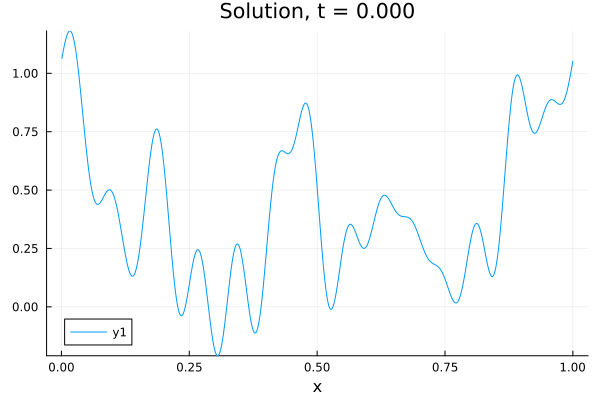

In [13]:
let
    nx = 1024
    x = LinRange(0.0, 1.0, nx + 1)[2:end]

    # Initial conditions (one sample vector)
    u₀ = create_initial_conditions(nx, 1)
    # u₀ = sin.(2π .* x)
    # u₀ = sin.(4π .* x)
    # u₀ = sin.(6π .* x)

    # Time stepping
    anim = Animation()
    u = solve_ode(
        f_shock,
        # f_central,
        u₀;
        μ = 5.0e-4,
        dt = 1.0e-4,
        nt = 5000,
        ncallback = 50,
        callback = (u, t, i) -> frame(
            anim,
            plot(
                x,
                u;
                xlabel = "x",
                ylims = extrema(u₀),
                # marker = :o,
                title = @sprintf("Solution, t = %.3f", t)
            ),
        ),
    )
    gif(anim)
end

This is typical for the Burgers equation: The initial conditions merge to
form a shock, which is eventually dampened due to the viscosity. If we let
the simulation go on, diffusion will take over and we get a smooth solution
and eventually $u$ becomes constant.

#### Exercise: Understanding the Burgers equation

The animation shows the velocity profile of a fluid.

- In which direction is the fluid moving?
- Rerun the above cell a couple of times to get different random initial
  conditions. Does the velocity always move in the same direction?
- Find a region where $u > 0$. In what direction is the curve moving?
- Find a region where $u < 0$. In what direction is the curve moving?
- Find a point where $u = 0$. Does this point move?

#### Exercise: Understanding the discretization

Choose one of the sine waves as initial conditions.
Change the resolution to `nx = 128`.
Run once with `f_shock` and once with `f_central`.
You can try with and without the `marker = :o` keyword to see
the discrete points better.

Questions:

- Is there something strange with `f_central`?
- On which side(s) of the shock is there a problem?
- Does this problem go away when you increase `nx`?

## Problem set-up for large eddy simulation (LES) with neural networks

We now assume that we are only interested in the large scale structures of the
flow. To compute those, we would ideally like to use a coarser resolution
($N_\text{LES}$) than the one needed to resolve all the features of the flow
($N_\text{DNS}$).

To define "large scales", we consider a discrete filter $\Phi \in
\mathbb{R}^{N_\text{LES} \times N_\text{DNS}}$, averaging multiple DNS grid
points into LES points. The filtered velocity field is defined by $\bar{u} =
\Phi u$. It is governed by the equation

$$
\frac{\mathrm{d} \bar{u}}{\mathrm{d} t} = f(\bar{u}) + c(u, \bar{u}),
$$

where $f$ is adapted to the grid of its input field $\bar{u}$ and
$c(u, \bar{u}) = \overline{f(u)} - f(\bar{u})$ is the commutator error
between the coarse grid and filtered fine grid right hand sides. Given
$\bar{u}$ only, this commutator error is **unknown**, and the equation
needs a closure model.

To close the equations, we approximate the unknown commutator error using a
closure model $m$ with parameters $\theta$:

$$
m(\bar{u}, \theta) \approx c(u, \bar{u}).
$$

We need to make two choices: $m$ and $\theta$. While the model $m$ will
be chosen based on our expertise of numerical methods and machine learning,
the parameters $\theta$ will be fitted using high fidelity simulation data.
We can then solve the LES equation

$$
\frac{\mathrm{d} \bar{v}}{\mathrm{d} t} = f(\bar{v}) + m(\bar{v}, θ),
$$

where the LES solution $\bar{v}$ is an approximation to the filtered DNS
solution $\bar{u}$, starting from the exact initial conditions $\bar{v}(0) =
\bar{u}(0)$.

Since the 1D Burgers equation does not create "turbulence" in the same way
as the 3D Navier-Stokes equations do, we choose to use a discretization
that is "bad" on coarse grids (the LES grid), but still performs fine on fine
grids (the DNS grid). This will give the neural network closure models some
work to do.

In [14]:
dns(u; μ) = f_central(u; μ)

dns (generic function with 1 method)

The following right hand side function includes the correction term, and thus
constitutes the LES right hand side.

In [15]:
les(u; μ, m, θ) = dns(u; μ) + m(u, θ)

les (generic function with 1 method)

### Data generation

This generic function creates a data structure containing filtered DNS data,
commutator errors and simulation parameters for a given filter $Φ$. We also
provide some default values for the initial conditions.

In [16]:
function create_data(nsample, Φ; μ, dt, nt, kmax = 10, decay = k -> (1 + abs(k))^(-6 / 5))
    # Resolution
    nx_les, nx_dns = size(Φ)

    # Grids
    x_les = LinRange(0.0, 1.0, nx_les + 1)[2:end]
    x_dns = LinRange(0.0, 1.0, nx_dns + 1)[2:end]

    # Output data
    data = (;
        # Filtered snapshots and commutator errors (including at t = 0)
        u = zeros(nx_les, nsample, nt + 1),
        c = zeros(nx_les, nsample, nt + 1),

        # Simulation-specific parameters
        dt,
        μ,
    )

    # DNS Initial conditions
    u₀ = create_initial_conditions(nx_dns, nsample; kmax, decay)

    # Save filtered solution and commutator error after each DNS time step
    function callback(u, t, i)
        ubar = Φ * u
        data.u[:, :, i+1] = ubar
        data.c[:, :, i+1] = Φ * dns(u; μ) - dns(ubar; μ)
    end

    # Do DNS time stepping (save after each step)
    u = solve_ode(dns, u₀; μ, dt, nt, callback, ncallback = 1)

    # Return data
    data
end

create_data (generic function with 1 method)

Now we set up an experiment. We need to decide on the following:

- Problem parameter: $\mu$
- LES resolution
- DNS resolution
- Discrete filter
- Number of initial conditions
- Simulation time: Too short, and we won't have time to detect instabilities
  created by our model; too long, and most of the data will be too smooth for
  a closure model to be needed (due to viscosity)

In addition, we will split our data into

- Training data (for choosing $\theta$)
- Validation data (just for monitoring training, choose when to stop)
- Testing data (for testing performance on unseen data)

In [17]:
# Resolution
nx_les = 64
nx_dns = 1024

# Grids
x_les = LinRange(0.0, 1.0, nx_les + 1)[2:end]
x_dns = LinRange(0.0, 1.0, nx_dns + 1)[2:end]

# Grid sizes
Δx_les = 1 / nx_les
Δx_dns = 1 / nx_dns

0.0009765625

We will use a Gaussian filter kernel, truncated to zero outside of $3 / 2$
filter widths.

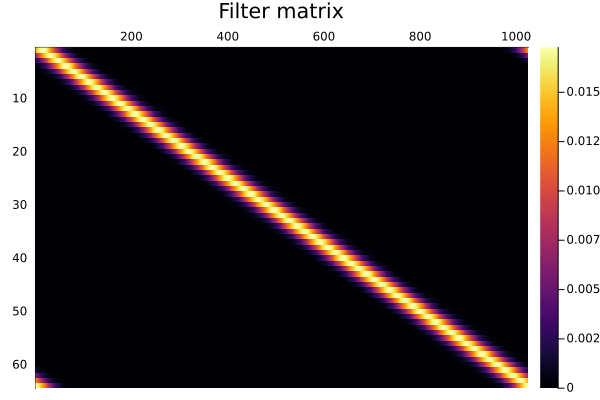

In [18]:
# Filter width
ΔΦ = 5 * Δx_les

# Filter kernel
gaussian(Δ, x) = sqrt(6 / π) / Δ * exp(-6x^2 / Δ^2)
top_hat(Δ, x) = (abs(x) ≤ Δ / 2) / Δ
kernel = gaussian

# Discrete filter matrix (with periodic extension and threshold for sparsity)
Φ = sum(-1:1) do z
    d = @. x_les - x_dns' - z
    @. kernel(ΔΦ, d) * (abs(d) ≤ 3 / 2 * ΔΦ)
end
Φ = Φ ./ sum(Φ; dims = 2) ## Normalize weights
Φ = sparse(Φ)
dropzeros!(Φ)
heatmap(Φ; yflip = true, xmirror = true, title = "Filter matrix")

To illustrate the closure problem, we will run an LES simulation without a closure model.
Consider the following setup:

[ Info: Saved animation to /tmp/jl_Vs7cvwDedY.gif


Plots.AnimatedGif("/tmp/jl_Vs7cvwDedY.gif")
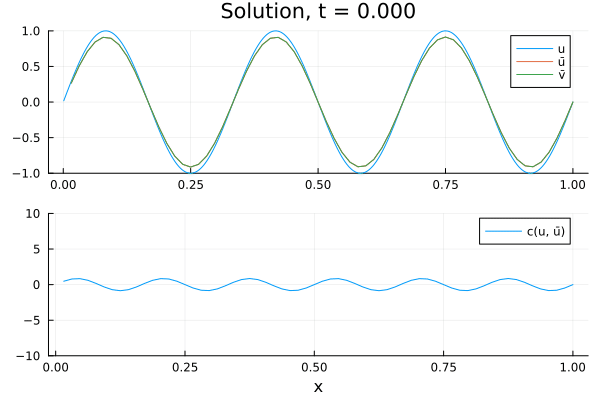

In [19]:
let
    μ = 5.0e-4
    u = sin.(6π * x_dns)
    ubar = Φ * u
    vbar = ubar
    dt = 1.0e-4
    anim = Animation()
    for it = 0:5000
        # Time step: Skip first step to get initial plot
        if it > 0
            u = step_rk4(dns, u, dt; μ)
            vbar = step_rk4(dns, vbar, dt; μ)
            ubar = Φ * u
        end

        # Plot
        if it % 50 == 0
            sol = plot(;
                ylims = (-1.0, 1.0),
                legend = :topright,
                title = @sprintf("Solution, t = %.3f", it * dt)
            )
            plot!(sol, x_dns, u; label = "u")
            plot!(sol, x_les, ubar; label = "ū")
            plot!(sol, x_les, vbar; label = "v̄")
            c = plot(
                x_les,
                Φ * dns(u; μ) - dns(ubar; μ);
                label = "c(u, ū)",
                legend = :topright,
                xlabel = "x",
                ylims = (-10.0, 10.0),
            )
            fig = plot(sol, c; layout = (2, 1))
            frame(anim, fig)
        end
    end
    gif(anim)
end

We observe the following:

- The DNS solution $u$ contains shocks, but these are not visible in the filtered
  DNS solution $\bar{u}$.
- The LES solution $\bar{v}$ does try to resolve the shocks, but does a very
  bad job. The discretization $f_\text{central}$ is also creating oscillations.
- We see that there is a clear mismatch between $\bar{u}$ (target) and $\bar{v}$
  (LES prediction). This is because we did not take into account the commutator
  error (bottom curve).
- The commutator error is large where $u$ has a shock, and small everywhere
  else. The "subgrid content" for the 1D Burgers equations is the stress
  caused by the subgrid shocks.

_The job of the closure model is to predict the bottom curve using the smooth
orange top curve only._

We now create the training, validation, and testing datasets.
We use a slightly different time step for testing to detect time step overfitting.

In [20]:
μ = 5.0e-4
data_train = create_data(10, Φ; μ, nt = 2000, dt = 1.0e-4);
data_valid = create_data(2, Φ; μ, nt = 500, dt = 1.3e-4);
data_test = create_data(3, Φ; μ, nt = 3000, dt = 1.1e-4);

The information about our problem is now fully contained in the data sets. We
can now choose the closure model to solve the problem.

### Loss function

To choose $\theta$, we will minimize a loss function using a gradient
descent based optimization method ("train" the neural network).
Since the model is used to predict the commutator error, the obvious choice
of loss function is the prior loss function

$$
L^\text{prior}(\theta) = \| m(\bar{u}, \theta) - c(u, \bar{u}) \|^2.
$$

This loss function has a simple computational chain, that is mostly comprised
of evaluating the neural network $m$ itself. Computing the gradient with
respect to $\theta$ is thus simple. The gradient is given by

$$
\frac{\mathrm{d} L^\text{prior}}{\mathrm{d} \theta}(\theta) = 2 (m(\bar{u},
\theta) - c(u, \bar{u}))^\mathsf{T}
\frac{\partial m}{\partial \theta}(\bar{u}, \theta),
$$

but we don't need to specify any of that, Zygote figures it out just fine on
its own.

We call this loss function "prior" since it only measures the error of the
prediction itself, and not the effect this error has on the LES
solution $\bar{v}_{\theta}$. Since instability in $\bar{v}_{\theta}$ is not
directly detected in this loss function, we add a regularization term to
penalize extremely large weights.

In [21]:
mean_squared_error(m, u, c, θ; λ) =
    sum(abs2, m(u, θ) - c) / sum(abs2, c) + λ * sum(abs2, θ) / length(θ)

mean_squared_error (generic function with 1 method)

We will only use a random subset `nuse` of all `nsample * nt`
solution snapshots at each loss evaluation. This random sampling creates a
random variable in the loss function, which becomes stochastic. Minimizing it
using gradient descent is thus called _stochastic gradient descent_.
The `Zygote.@ignore` macro just tells the AD engine Zygote not to complain
about the random index selection.

In [22]:
function create_randloss_commutator(m, data; nuse = 20, λ = 1.0e-8)
    (; u, c) = data
    u = reshape(u, size(u, 1), :)
    c = reshape(c, size(c, 1), :)
    nsample = size(u, 2)
    @assert nsample ≥ nuse
    function randloss(θ)
        i = Zygote.@ignore sort(shuffle(1:nsample)[1:nuse])
        uuse = Zygote.@ignore u[:, i]
        cuse = Zygote.@ignore c[:, i]
        mean_squared_error(m, uuse, cuse, θ; λ)
    end
end

create_randloss_commutator (generic function with 1 method)

Ideally, we want the LES simulation to produce the filtered DNS velocity
$\bar{u}$. The prior loss does not guarantee or enforce this.
We can alternatively minimize the posterior loss function

$$
L^\text{post}(\theta) = \| \bar{v}_\theta - \bar{u} \|^2,
$$

where $\bar{v}_\theta$ is the solution to the LES equation for the given
parameters. This loss function contains more information about the effect of
$\theta$ than $L^\text{prior}$. However, it has a significantly longer
computational chain, as it includes time stepping in addition to the neural
network evaluation itself. Computing the gradient with respect to $\theta$ is
more costly, and also requires an AD-friendly time stepping scheme (which we
have already taken care of above). Note that it is also possible to compute
the gradient of the time-continuous ODE instead of the time-discretized one
as we do here. It involves solving an adjoint ODE backwards in time, which in
turn has to be discretized. Our approach here is therefore called
"discretize-then-optimize", while the adjoint ODE method is called
"optimize-then-discretize". The [SciML](https://github.com/sciml) time
steppers include both methods, as well as useful strategies for evaluating
them efficiently.

For the posterior loss function, we provide the right hand side function
`model` (including closure), reference trajectories `u`, and model
parameters. We compute the error between the predicted and reference trajectories
at each time point.

In [23]:
function trajectory_loss(model, u; dt, params...)
    nt = size(u, 3) - 1
    loss = 0.0
    v = u[:, :, 1]
    for i = 1:nt
        v = step_rk4(model, v, dt; params...)
        ui = u[:, :, i+1]
        loss += sum(abs2, v - ui) / sum(abs2, ui)
    end
    loss / nt
end

trajectory_loss (generic function with 1 method)

We also make a non-squared variant for error analysis.

In [24]:
function trajectory_error(model, u; dt, params...)
    nt = size(u, 3) - 1
    loss = 0.0
    v = u[:, :, 1]
    for i = 1:nt
        v = step_rk4(model, v, dt; params...)
        ui = u[:, :, i+1]
        loss += norm(v - ui) / norm(ui)
    end
    loss / nt
end

trajectory_error (generic function with 1 method)

To limit the length of the computational chain, we only unroll `n_unroll`
time steps at each loss evaluation. The time step from which to unroll is
chosen at random at each evaluation, as are the initial conditions (`nuse`).

The non-trainable parameters (e.g. $\mu$) are passed in `params`.

In [25]:
function create_randloss_trajectory(model, data; nuse = 1, n_unroll = 10, params...)
    (; u, dt) = data
    nsample = size(u, 2)
    nt = size(u, 3)
    @assert nt ≥ n_unroll
    @assert nsample ≥ nuse
    function randloss(θ)
        isample = Zygote.@ignore sort(shuffle(1:nsample)[1:nuse])
        istart = Zygote.@ignore rand(1:nt-n_unroll)
        it = Zygote.@ignore istart:istart+n_unroll
        uuse = Zygote.@ignore u[:, isample, it]
        trajectory_loss(model, uuse; dt, params..., θ)
    end
end

create_randloss_trajectory (generic function with 1 method)

### Training settings

During training, we will monitor the error on the validation dataset with a
callback. We will plot the history of the prior and posterior errors.

In [26]:
# Initial empty history
initial_callbackstate() = (; ihist = Int[], ehist_prior = zeros(0), ehist_post = zeros(0))

# Plot convergence
function plot_convergence(state, data)
    e_post_ref = trajectory_error(dns, data.u; data.dt, data.μ)
    fig = plot(; yscale = :log10, xlabel = "Iterations", title = "Relative error")
    hline!(fig, [1.0]; color = 1, linestyle = :dash, label = "Prior: No model")
    plot!(fig, state.ihist, state.ehist_prior; color = 1, label = "Prior: Model")
    hline!(fig, [e_post_ref]; color = 2, linestyle = :dash, label = "Posterior: No model")
    plot!(fig, state.ihist, state.ehist_post; color = 2, label = "Posterior: Model")
    fig
end

# Create callback for given model and dataset
function create_callback(m, data; doplot = false)
    (; u, c, dt, μ) = data
    uu, cc = reshape(u, size(u, 1), :), reshape(c, size(c, 1), :)
    function callback(i, θ, state)
        (; ihist, ehist_prior, ehist_post) = state
        eprior = norm(m(uu, θ) - cc) / norm(cc)
        epost = trajectory_error(les, u; dt, μ, m, θ)
        state = (;
            ihist = vcat(ihist, i),
            ehist_prior = vcat(ehist_prior, eprior),
            ehist_post = vcat(ehist_post, epost),
        )
        doplot && display(plot_convergence(state, data))
        @printf "Iteration %d,\t\tprior error: %.4g,\t\tposterior error: %.4g\n" i eprior epost
        state
    end
end

create_callback (generic function with 1 method)

For training, we have to initialize an optimizer and a callbackstate (lots of
state initilization in this session)

In [27]:
initial_trainstate(optimiser, θ) = (;
    opt = Optimisers.setup(optimiser, θ),
    θ,
    callbackstate = initial_callbackstate(),
    istart = 0,
)

"""
    train(; loss, opt, θ, istart, niter, ncallback, callback, callbackstate)

Perform `niter` iterations of gradient descent on `loss(θ)` for given `optimiser`.
Every `ncallback` iteration, call `callback(i, θ, callbackstate)` and update
callback state, where `i` starts at `istart`.

Return a named tuple `(; opt, θ, callbcackstate)` containing the updated
optimizer state, parameters and callback state.
"""
function train(; loss, opt, θ, istart, niter, ncallback, callback, callbackstate)
    for i = 1:niter
        ∇ = first(gradient(loss, θ))
        opt, θ = Optimisers.update(opt, θ, ∇)
        i % ncallback == 0 && (callbackstate = callback(istart + i, θ, callbackstate))
    end
    istart += niter
    (; opt, θ, callbackstate, istart)
end

Main.var"##225".train

### Model architecture

We are free to choose the model architecture $m$. Here, we will consider two
neural network architectures. The following wrapper returns the model and
initial parameters for a Lux `Chain`. Note: If the chain includes
state-dependent layers such as `Dropout` (which modify their RNGs at each
evaluation), this wrapper should not be used.

In [28]:
function create_model(chain, rng)
    # Create parameter vector and empty state
    θ, state = Lux.setup(rng, chain)

    # Convert nested named tuples of arrays to a ComponentArray,
    # which behaves like a long vector
    θ = ComponentArray(θ)

    # Convenience wrapper for empty state in input and output
    m(v, θ) = first(chain(v, θ, state))

    # Return model and initial parameters
    m, θ
end

create_model (generic function with 1 method)

#### Convolutional neural network architecture (CNN)

A CNN is an interesting closure model for the following reasons:

- The parameters are sparse, since the kernels are reused for each output
- A convolutional layer can be seen as a discretized differential operator
- Translation invariance, a desired physical property of the commutator
  error we try to predict, is baked in.

However, it only uses local spatial information, whereas an ideal closure
model could maybe recover some of the missing information in far-away values.

Note that we start by adding input channels, stored in a tuple of functions.
The Burgers RHS has a square term, so maybe the closure model can make use of
the same "structure". See Melchers [^2].

In [29]:
"""
    create_cnn(;
        radii,
        channels,
        activations,
        use_bias,
        rng,
        input_channels = (u -> u,),
    )

Create CNN.

Keyword arguments:

- `radii`: Vector of kernel radii
- `channels`: Vector layer output channel numbers
- `activations`: Vector of activation functions
- `use_bias`: Vectors of indicators for using bias
- `rng`: Random number generator
- `input_channels`: Tuple of input channel contstructors

Return `(cnn, θ)`, where `cnn(v, θ)` acts like a force on `v`.
"""
function create_cnn(;
    radii,
    channels,
    activations,
    use_bias,
    rng,
    input_channels = (u -> u,),
)
    @assert channels[end] == 1 "A unique output channel is required"

    # Add number of input channels
    channels = [length(input_channels); channels]

    # Padding length
    padding = sum(radii)

    # Create CNN
    create_model(
        Chain(
            # Create singleton channel
            u -> reshape(u, size(u, 1), 1, size(u, 2)),

            # Create input channels
            u -> hcat(map(i -> i(u), input_channels)...),

            # Add padding so that output has same shape as commutator error
            u -> pad_circular(u, padding; dims = 1),

            # Some convolutional layers
            (
                Conv(
                    (2 * radii[i] + 1,),
                    channels[i] => channels[i+1],
                    activations[i];
                    use_bias = use_bias[i],
                    init_weight = glorot_uniform_64,
                ) for i ∈ eachindex(radii)
            )...,

            # Remove singleton output channel
            u -> reshape(u, size(u, 1), size(u, 3)),
        ),
        rng,
    )
end

Main.var"##225".create_cnn

#### Eddy viscosity models

A common closure models consists of computing a turbulent viscosity
$\mu_t$ from the large scale velocity field $\bar{v}$. Here we will
use one of the other closure models to predict that viscosity. Since
this term will be non-constant in space, we need to put it "in between"
the two spatial derivatives in the diffusion term, similarly to how
we add the non-constant numerical viscosity in $f_\text{shock}$. In
continuous space, the closure model would be

$$
m(\bar{u})(x) = \frac{\partial}{\partial x} \left( \mu_t(\bar{u})(x) \frac{\partial \bar{u}}{\partial x} \right).
$$

In [30]:
create_eddy_viscosity(turb) =
    function eddy_visosity(u, θ)
        Δx = 1 / size(u, 1)
        u₊ = circshift(u, -1)
        μ = turb(u, θ)
        ϕ₊ = @. -μ * (u₊ - u) / Δx
        ϕ₋ = circshift(ϕ₊, 1)
        @. -(ϕ₊ - ϕ₋) / Δx
    end

create_eddy_viscosity (generic function with 1 method)

#### Fourier neural operator architecture (FNO)

A Fourier neural operator [^3] is a network composed of _Fourier Layers_ (FL).
A Fourier layer $u \mapsto w$ transforms the continuous function $u$
into the contiunous function $w$.
It is defined by the following expression in physical space:

$$
w(x) = \sigma \left( z(x) + W u(x) \right), \quad \forall x \in \Omega,
$$

where $z$ is defined by its Fourier series coefficients $\hat{z}(k) = R(k)
\hat{u}(k)$ for all wavenumbers $k \in \mathbb{Z}$ and some weight matrix
collection $R(k) \in \mathbb{C}^{n_\text{out} \times n_\text{in}}$. The
important part is the following choice: $R(k) = 0$ for $| k | >
k_\text{max}$ for some $k_\text{max}$. This truncation makes the FNO
applicable to any spatial $N$-discretization of $u$ and $w$ as long as $N > 2
k_\text{max}$. The same weight matrices may be reused for different
discretizations.

Note that a standard convolutional layer (CL) can also be written in spectral
space, where the spatial convolution operation becomes an wavenumber
element-wise product. The effective difference between the layers of a FNO
and CNN becomes the following:

- A FL does not include the bias of a CL
- The spatial part of a FL corresponds to the central weight of the CL
  kernel
- A CL is chosen to be sparse in physical space (local kernel with radius $r
  \ll N / 2$), and would therefore be dense in spectral space ($k_\text{max} =
  N / 2$)
- The spectral part of a FL is chosen to be sparse in spectral space
  ($k_\text{max} \ll N / 2$), and would therefore dense in physical space (it
  can be written as a convolution stencil with radius $r = N / 2$)

Lux lets us define
our own layer types. All functions should be "pure" (functional programming),
meaning that the same inputs should produce the same outputs. In particular,
this also applies to random number generation and state modification. The
weights are stored in a vector outside the layer, while the layer itself
contains information for weight initialization.

If you are not familiar with Julia, feel free to go quickly through
the following code cells. Just note that all variables have a type (e.g.
`kmax::Int` means that `kmax` is an integer), but most of the time we don't have
to declare types explicitly. Structures (`struct`s) can be
parametrized and specialized for the types we give them in the constructor
(e.g. `σ::A` means that a specialized version of the struct is compiled for
each activation function we give it, creating an optimized FourierLayer for
`σ = relu` where `A = typeof(relu)`, and a different version optimized for `σ
= tanh` where `A = typeof(tanh)` etc.). Here our layer will have the type
`FourierLayer`, with a default and custom constructor (two constructor
methods, the latter making use of the default).

In [31]:
struct FourierLayer{A,F} <: Lux.AbstractLuxLayer
    kmax::Int
    cin::Int
    cout::Int
    σ::A
    init_weight::F
end

FourierLayer(kmax, ch::Pair{Int,Int}; σ = identity, init_weight = glorot_uniform_64) =
    FourierLayer(kmax, first(ch), last(ch), σ, init_weight)

Main.var"##225".FourierLayer

We also need to specify how to initialize the parameters and states. The
Fourier layer does not have any hidden states that are modified. The below
code adds methods to some existing Lux functions. These new methods are only
used when the functions encounter `FourierLayer` inputs. For example, in our
current environment, we have this many methods for the function
`Lux.initialparameters` (including `Dense`, `Conv`, etc.):

In [32]:
length(methods(Lux.initialparameters))

24

Now, when we add our own method, there should be one more in the method
table.

In [33]:
Lux.initialparameters(rng::AbstractRNG, (; kmax, cin, cout, init_weight)::FourierLayer) = (;
    spatial_weight = init_weight(rng, cout, cin),
    spectral_weights = init_weight(rng, kmax + 1, cout, cin, 2),
)
Lux.initialstates(::AbstractRNG, ::FourierLayer) = (;)
Lux.parameterlength((; kmax, cin, cout)::FourierLayer) =
    cout * cin + (kmax + 1) * 2 * cout * cin
Lux.statelength(::FourierLayer) = 0

# Pretty printing
function Base.show(io::IO, (; kmax, cin, cout, σ)::FourierLayer)
    print(io, "FourierLayer(", kmax)
    print(io, ", ", cin, " => ", cout)
    print(io, "; σ = ", σ)
    print(io, ")")
end

# One more method now
length(methods(Lux.initialparameters))

25

This is one of the advantages of Julia: As users we can extend functions from
other authors without modifying their package or being forced to "inherit"
their data structures (classes). This has created an interesting package
ecosystem. For example, [ODE
solvers](https://github.com/SciML/OrdinaryDiffEq.jl) can be used with exotic
number types such as `BigFloat`, dual numbers, or quaternions. [Iterative
solvers](https://github.com/JuliaLinearAlgebra/IterativeSolvers.jl)
work out of the box with different array types, including various [GPU
arrays](https://github.com/JuliaGPU/GPUArrays.jl), without actually
containing any GPU array specific code.

We now define how to pass inputs through a Fourier layer. In tensor notation,
multiple samples can be processed at the same time. We therefore assume the
following:

- Input size: `(nx, cin, nsample)`
- Output size: `(nx, cout, nsample)`

In [34]:
# This makes FourierLayers callable
function ((; kmax, cout, cin, σ)::FourierLayer)(x, params, state)
    nx = size(x, 1)

    # Destructure params
    # The real and imaginary parts of R are stored in two separate channels
    W = params.spatial_weight
    W = reshape(W, 1, cout, cin)
    R = params.spectral_weights
    R = selectdim(R, 4, 1) .+ im .* selectdim(R, 4, 2)

    # Spatial part (applied point-wise)
    y = reshape(x, nx, 1, cin, :)
    y = sum(W .* y; dims = 3)
    y = reshape(y, nx, cout, :)

    # Spectral part (applied mode-wise)
    #
    # Steps:
    #
    # - go to complex-valued spectral space
    # - chop off high wavenumbers
    # - multiply with weights mode-wise
    # - pad with zeros to restore original shape
    # - go back to real valued spatial representation
    ikeep = 1:kmax+1
    nkeep = kmax + 1
    z = rfft(x, 1)
    z = z[ikeep, :, :]
    z = reshape(z, nkeep, 1, cin, :)
    z = sum(R .* z; dims = 3)
    z = reshape(z, nkeep, cout, :)
    z = vcat(z, zeros(nx ÷ 2 + 1 - kmax - 1, size(z, 2), size(z, 3)))
    z = irfft(z, nx, 1)

    # Outer layer: Activation over combined spatial and spectral parts
    # Note: Even though high wavenumbers are chopped off in `z` and may
    # possibly not be present in the input at all, `σ` creates new high
    # wavenumbers. High wavenumber functions may thus be represented using a
    # sequence of Fourier layers. In this case, the `y`s are the only place
    # where information contained in high input wavenumbers survive in a
    # Fourier layer.
    w = σ.(z .+ y)

    # Fourier layer does not modify state
    w, state
end

We will chain some Fourier layers, with a final dense layer. As for the CNN,
we allow for a tuple of predetermined input channels.

In [35]:
"""
    create_fno(; channels, kmax, activations, rng, input_channels = (u -> u,))

Create FNO.

Keyword arguments:

- `channels`: Vector of output channel numbers
- `kmax`: Vector of cut-off wavenumbers
- `activations`: Vector of activation functions
- `rng`: Random number generator
- `input_channels`: Tuple of input channel constructors

Return `(fno, θ)`, where `fno(v, θ)` acts like a force on `v`.
"""
function create_fno(; channels, kmax, activations, rng, input_channels = (u -> u,))
    # Add number of input channels
    channels = [length(input_channels); channels]

    # Model
    create_model(
        Chain(
            # Create singleton channel
            u -> reshape(u, size(u, 1), 1, size(u, 2)),

            # Create input channels
            u -> hcat(map(i -> i(u), input_channels)...),

            # Some Fourier layers
            (
                FourierLayer(kmax[i], channels[i] => channels[i+1]; σ = activations[i]) for
                i ∈ eachindex(kmax)
            )...,

            # Put channels in first dimension
            u -> permutedims(u, (2, 1, 3)),

            # Compress with a final dense layer
            Dense(channels[end] => 2 * channels[end], gelu),
            Dense(2 * channels[end] => 1; use_bias = false),

            # Put channels back after spatial dimension
            u -> permutedims(u, (2, 1, 3)),

            # Remove singleton channel
            u -> reshape(u, size(u, 1), size(u, 3)),
        ),
        rng,
    )
end

Main.var"##225".create_fno

## Getting to business: Training and comparing closure models

We now create a closure model. Note that the last activation is `identity`, as we
don't want to restrict the output values. We can inspect the structure in the
wrapped Lux `Chain`.

In [36]:
m_cnn, θ_cnn = create_cnn(;
    radii = [2, 2, 2, 2],
    channels = [8, 8, 8, 1],
    activations = [leakyrelu, leakyrelu, leakyrelu, identity],
    use_bias = [true, true, true, false],
    input_channels = (u -> u, u -> u .^ 2),
    rng,
)
m_cnn.chain

Chain(
    layer_1 = WrappedFunction(#56),
    layer_2 = WrappedFunction(#57),
    layer_3 = WrappedFunction(#59),
    layer_4 = Conv((5,), 2 => 8, leakyrelu),  # 88 parameters
    layer_5 = Conv((5,), 8 => 8, leakyrelu),  # 328 parameters
    layer_6 = Conv((5,), 8 => 8, leakyrelu),  # 328 parameters
    layer_7 = Conv((5,), 8 => 1, use_bias=false),  # 40 parameters
    layer_8 = WrappedFunction(#61),
)         # Total: 784 parameters,
          #        plus 0 states.

For the eddy visosity, we enforce a positive value with `gelu`,
as we do not want any anti-diffusion.

In [37]:
turb, θ_eddy = create_cnn(;
    radii = [2, 2, 2, 2],
    channels = [8, 8, 8, 1],
    activations = [leakyrelu, leakyrelu, leakyrelu, gelu],
    use_bias = [true, true, true, false],
    input_channels = (u -> u, u -> u .^ 2),
    rng,
)
θ_eddy = θ_eddy / 10
m_eddy = create_eddy_viscosity(turb)
m_eddy.turb.chain

Chain(
    layer_1 = WrappedFunction(#56),
    layer_2 = WrappedFunction(#57),
    layer_3 = WrappedFunction(#59),
    layer_4 = Conv((5,), 2 => 8, leakyrelu),  # 88 parameters
    layer_5 = Conv((5,), 8 => 8, leakyrelu),  # 328 parameters
    layer_6 = Conv((5,), 8 => 8, leakyrelu),  # 328 parameters
    layer_7 = Conv((5,), 8 => 1, gelu, use_bias=false),  # 40 parameters
    layer_8 = WrappedFunction(#61),
)         # Total: 784 parameters,
          #        plus 0 states.

In [38]:
m_fno, θ_fno = create_fno(;
    channels = [5, 5, 5, 5],
    kmax = [16, 16, 16, 8],
    activations = [gelu, gelu, gelu, identity],
    input_channels = (u -> u, u -> u .^ 2),
    rng,
)
m_fno.chain

Chain(
    layer_1 = WrappedFunction(#75),
    layer_2 = WrappedFunction(#76),
    layer_3 = FourierLayer(16, 2 => 5; σ = gelu),  # 350 parameters
    layer_4 = FourierLayer(16, 5 => 5; σ = gelu),  # 875 parameters
    layer_5 = FourierLayer(16, 5 => 5; σ = gelu),  # 875 parameters
    layer_6 = FourierLayer(8, 5 => 5; σ = identity),  # 475 parameters
    layer_7 = WrappedFunction(#79),
    layer_8 = Dense(5 => 10, gelu),     # 60 parameters
    layer_9 = Dense(10 => 1, use_bias=false),  # 10 parameters
    layer_10 = WrappedFunction(#80),
    layer_11 = WrappedFunction(#81),
)         # Total: 2_645 parameters,
          #        plus 0 states.

In [39]:
m, θ, label = m_cnn, θ_cnn, "CNN";
# m, θ, label = m_eddy, θ_eddy, "Eddy";
# m, θ, label = m_fno, θ_fno, "FNO";

Choose loss

In [40]:
loss_prior = create_randloss_commutator(m, data_train; nuse = 50);

In [41]:
loss_post =
    create_randloss_trajectory(les, data_train; nuse = 3, n_unroll = 10, data_train.μ, m);

In [42]:
loss = loss_prior;
# loss = loss_post;

Initialize training state. Note that we have to provide an optimizer, here
`Adam(η)` where `η` is the learning rate [^4]. This optimizer exploits the
random nature of our loss function.

In [43]:
trainstate = initial_trainstate(Adam(1.0e-3), θ);

Model warm-up: trigger compilation and get indication of complexity

In [44]:
loss(θ)
gradient(loss, θ);
@time loss(θ);
@time gradient(loss, θ);

  0.001081 seconds (389 allocations: 1.139 MiB)
  0.005515 seconds (2.21 k allocations: 3.477 MiB)


Train the model. The cell below can be repeated to continue training where the
previous training session left off.
If you run this in a notebook, `doplot = true` will create a lot of plots
below the cell.

Iteration 20,		prior error: 0.985,		posterior error: 0.02898
Iteration 40,		prior error: 0.9562,		posterior error: 0.02801
Iteration 60,		prior error: 0.8898,		posterior error: 0.02574
Iteration 80,		prior error: 0.8638,		posterior error: 0.02533
Iteration 100,		prior error: 0.8146,		posterior error: 0.02337
Iteration 120,		prior error: 0.7755,		posterior error: 0.02224
Iteration 140,		prior error: 0.7387,		posterior error: 0.02093
Iteration 160,		prior error: 0.6819,		posterior error: 0.0196
Iteration 180,		prior error: 0.623,		posterior error: 0.01819
Iteration 200,		prior error: 0.6038,		posterior error: 0.01772
Iteration 220,		prior error: 0.5712,		posterior error: 0.01675
Iteration 240,		prior error: 0.5329,		posterior error: 0.0157
Iteration 260,		prior error: 0.5587,		posterior error: 0.01624
Iteration 280,		prior error: 0.5146,		posterior error: 0.01502
Iteration 300,		prior error: 0.508,		posterior error: 0.0148
Iteration 320,		prior error: 0.5132,		posterior error: 0.01481
It

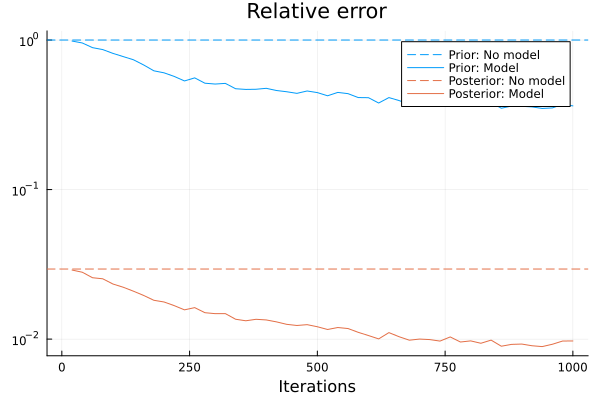

In [45]:
trainstate = train(;
    trainstate...,
    loss,
    niter = 1000,
    ncallback = 20,
    callback = create_callback(m, data_valid; doplot = false),
)
plot_convergence(trainstate.callbackstate, data_valid)

Final model weights

In [46]:
(; θ) = trainstate;

### Model performance

We will now make a comparison between our closure model, the baseline "no closure" model,
and the reference testing data.

In [47]:
println("Relative posterior errors:")
e0 = trajectory_error(dns, data_test.u; data_test.dt, data_test.μ)
e = trajectory_error(les, data_test.u; data_test.dt, data_test.μ, m, θ)
println("m=0:\t$e0")
println("$label:\t$e")

Relative posterior errors:
m=0:	0.1170540997945787
CNN:	0.022370874785168183


Let's also plot the LES solutions with and without closure model

[ Info: Saved animation to /tmp/jl_9gHWLKv03Y.gif


Plots.AnimatedGif("/tmp/jl_9gHWLKv03Y.gif")
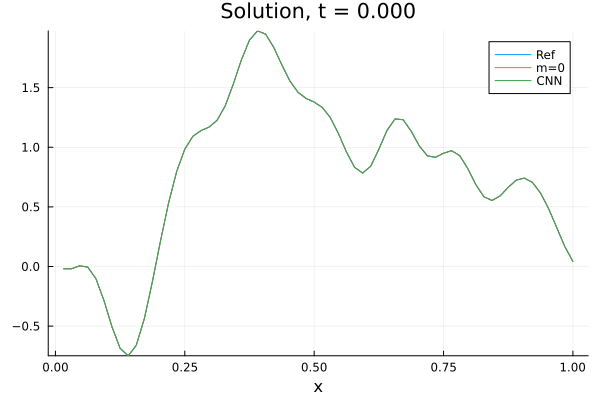

In [48]:
let
    (; u, dt, μ) = data_test
    u = u[:, 1, :]
    nt = size(u, 2) - 1
    v0 = u[:, 1]
    v = u[:, 1]
    anim = Animation()
    for it = 0:nt
        # Time step: Skip first step to get initial plot
        if it > 0
            v0 = step_rk4(dns, v0, dt; μ)
            v = step_rk4(les, v, dt; μ, m, θ)
        end

        # Plot
        if it % 50 == 0
            fig = plot(;
                ylims = extrema(u[:, 1]),
                xlabel = "x",
                title = @sprintf("Solution, t = %.3f", it * dt),
                legend = :topright,
            )
            plot!(fig, x_les, u[:, it+1]; label = "Ref")
            plot!(fig, x_les, v0; label = "m=0")
            plot!(fig, x_les, v; label)
            frame(anim, fig)
        end
    end
    gif(anim)
end

## Modeling exercises

To get confident with modeling ODE right hand sides using machine learning,
the following exercises can be useful.

### 1. Trajectory fitting (posterior loss function)

1. Fit a closure model using the posterior loss function.
1. Investigate the effect of the parameter `n_unroll`. Try for example
   `@time randloss(θ)` for `n_unroll = 10` and `n_unroll = 20`
   (execute `randloss` once first to trigger compilation).
1. Discuss the statement "$L^\text{prior}$ and $L^\text{post}$ are almost the
   same when `n_unroll = 1`" with your neighbour. Are they exactly the same if
   we use forward Euler ($u^{n + 1} = u^n + \Delta t f(u^n)$) instead of RK4?

### 2. Naive neural closure model

Recreate the CNN or FNO model without the additional square input channel
(prior physical knowledge).
The input should only have one singleton channel (pass the
keyword argument `input_channels = (u -> u,)` to the constructor).
Do you expect this version to perform better or worse than with a square
channel?

### 3. Neural ODE (brute force right hand side)

1. Observe that, if we really wanted to, we could skip the term $f(\bar{v})$
   entirely, hoping that $m$ will be able to model it directly (in addition
   to the commutator error). The resulting model is

   $$
   \frac{\mathrm{d} \bar{v}}{\mathrm{d} t} = m(\bar{v}, \theta).
   $$

   This is known as a _Neural ODE_ (see Chen [^5]).
1. Define a model that predicts the _entire_ right hand side.
   This can be done by using the following little "hack":

   - Create your model `m_entire_rhs, θ_entire_rhs = create_cnn(...)`
   - Define the effective closure model
     `m_effective(u, θ) = m_entire_rhs(u, θ) - dns(u; μ)`.

1. Train the CNN or FNO for `m_effective`.
   Is the model able to represent the solution correctly?

### 4. Learning the discretization

1. Make a new instance of the CNN closure, called `cnn_linear` with parameters
   `θ_cnn_linear`, which only has one convolutional layer.
   This model should still add the square input channel.
1. Observe that the simple Burgers DNS RHS $f_\text{central}$ can actually
   be expressed in its entirety using this model, i.e.

   $$
   f_\text{central}(u) = \mathop{\text{CNN}}(u, \theta).
   $$

   - What is the kernel radius?
   - Should there still be a nonlinear activation function?
   - What is the exact expression for the model weights and bias?

1. "Improve" the discretization $f_\text{central}$:

   - Choose a kernel radius for `cnn_linear` that is larger than the
     one of `f_central`.
   - Train the model.
   - What does the resulting kernel stencil (`Array(θ_cnn_linear)`) look like?
     Does it resemble the one of `f_central`?

1. Observe that if we really wanted to, we could do the same for the more
   complicated Burgers right hand side $f_\text{shock}$. Some extra
   difficulties in this version of $f$:

   - It contains an absolute value (in the numerical viscosity)
   - It contains cross terms $u_n u_{n + 1}$ (instead of element-wise squares
     $u_n^2$)

   If we use a CNN with two layers (instead of one) and with
   $\sigma(x) = \mathop{\text{relu}}(x) = \max(0, x)$ as an activation
   function between the two layers, then the absolute value can be written
   as the sum of two $\mathop{\text{relu}}$ functions with
   $|x| = \mathop{\text{relu}}(x) + \mathop{\text{relu}}(-x)$.
   Expressions on the same level without absolute value can also
   be written as a sum of two $\mathop{\text{relu}}$ functions with
   $x = \mathop{\text{relu}}(x) - \mathop{\text{relu}}(-x)$.
   For the cross term, we just add it in the input channel layer.

So, a simple discretization $f_\text{central}$ can be written as a one layer
CNN. A better discretization $f_\text{shock}$ can be written as a
two layer CNN... What can we do with an $n$ layer CNN?

Final question: What is a closure model? Are we just learning a better
coarse discretization? Discuss with your neighbour.

## References

[^1]: Antony Jameson,
      _Energy Estimates for Nonlinear Conservation Laws with Applications to
      Solutions of the Burgers Equation and One-Dimensional Vicous Flow in a
      Shock Tube by Central Difference Schemes_,
      18th AIAA Computational Fluid Dynamics Conference,
      2007,
      <https://doi.org/10.2514/6.2007-4620>

[^2]: Hugo Melchers, Daan Crommelin, Barry Koren, Vlado Menkovski, Benjamin
      Sanderse,
      _Comparison of neural closure models for discretised PDEs_,
      Computers & Mathematics with Applications,
      Volume 143,
      2023,
      Pages 94-107,
      ISSN 0898-1221,
      <https://doi.org/10.1016/j.camwa.2023.04.030>.

[^3]: Z. Li, N. Kovachki, K. Azizzadenesheli, B. Liu, K. Bhattacharya, A.
      Stuart, and A. Anandkumar.
      _Fourier neural operator for parametric partial differential
      equations._
      arXiv:[2010.08895](https://arxiv.org/abs/2010.08895),
      2021.

[^4]: D. P. Kingma and J. Ba.
      _Adam: A method for stochastic optimization_.
      arxiv:[1412.6980](https://arxiv.org/abs/1412.6980),
      2014.

[^5]: R. T. Q. Chen, Y. Rubanova, J. Bettencourt, and D. Duvenaud.
      _Neural Ordinary Differential Equations_.
      arXiv:[1806.07366](https://arxiv.org/abs/1806.07366),
      2018.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*